<img src='http://www.u.arizona.edu/~hammond/hltlogo1.png' style="float:right">

Linguistics 578<br>
Fall 2022<br>
Hammond

## Things to remember about any homework assignment:

1. For this assignment, you will edit this jupyter notebook and turn it in. Do not turn in pdf files or separate `.py` files.
1. Late work is not accepted.
1. Given the way I grade, you should try to answer *every* question, even if you don't like your answer or have to guess.
1. You may *not* use `python` modules that we have not already used in class.
1. You may certainly talk to your classmates about the assignment, but everybody must turn in *their own* work. It is not acceptable to turn in work that is essentially the same as the work of classmates.
1. All code must run. It doesn't have to be perfect, it may not do all that you want it to do, but it must run without error.
1. Code must run in reasonable time. Assume that if it takes more than *5 minutes* to run (on your machine), that's too long.
1. Please do not add, remove, or copy autograded cells.
1. Make sure to select `restart, run all cells` from the `kernel` menu when you're done and before you turn this in!

***

***my name***: Rachel 

***people I talked to about the assignment***:

***

## Homework #6

Here are the imports. Please do not import anything else.

In [1]:
import os,re
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio

1. We need to use the `kal` database, so here's a question that just lets you specify where it is and then checks that. (Please leave the first two comment lines in place and just add your own below.)

In [2]:
#kal = '/mhdata/cmu_us_kal_diphone/'
#kal = ?
kal = '/mnt/c/users/rhans/Documents/578 Speech Tech I/Week 6/cmu_us_kal_diphone/'
#raise NotImplementedError()

In [3]:
assert len(os.listdir(kal)) == 20

We need these from this week's notebook. I've converted the code that creates the diphone database into a function. Make sure the run the cell below before going on.

In [4]:
def getbit(start,end,filename,dirname=kal):
    sr,w = wavfile.read(dirname+'wav/'+filename)
    startidx = int(sr * start)
    endidx = int(sr*end)
    return w[startidx:endidx]

def makeDiphones(where):
    diphones = {}
    for i in range(1,1350):
        filename = str(i)
        while len(filename) < 4: filename = '0' + filename
        filename = 'kal_' + filename + '.lab'
        f = open(kal+'lab/'+filename,'r')
        t = f.read()
        f.close()
        t = re.sub(' 26 ','',t)
        t = t.split('\n')
        t = t[3:-1]
        fset = []
        start = 0
        for line in t:
            bits = line.split('\t')
            bits = bits[1:]
            fset.append((float(start),float(bits[0]),bits[1]))
            start = bits[0]
        i = 1
        while i < len(fset):
            diphone = fset[i-1][2] + '-' + fset[i][2]
            start = (fset[i-1][1] - fset[i-1][0])/2 + fset[i-1][0]
            end = (fset[i][1] - fset[i][0])/2 + fset[i][0]
            filename = re.sub('\.lab$','.wav',filename)
            triple = (filename,start,end)
            if diphone in diphones:
                diphones[diphone].append(triple)
            else:
                diphones[diphone] = [triple]
            i += 1
    return diphones

diphones = makeDiphones(kal)

2. For this question, you need to download and unzip the CMU pronouncing dictionary from [here](https://github.com/Alexir/CMUdict). (Again, do not remove the first two lines below; just add your own below.)

In [5]:
#cmufile = '/mhdata/CMUdict-master/cmudict-0.7b'
#cmufile = ?
cmufile = '/mnt/c/users/rhans/Documents/578 Speech Tech I/Week 6/CMUdict/cmudict-0.7b'
#raise NotImplementedError()

In [6]:
f = open(cmufile,'rb')
t = f.read()
f.close()
cmudict = t.decode('ISO-8859-1')
assert np.isclose(len(cmudict),3865710,atol=2)

3. Your task is to parse the `cmudict` variable into a dictionary from words to letter sequences. Be mindful of the following:
  1. The file format is funky.
  2. There may be errors and irregularities to recover from.
  3. You have to remove the header lines and final empty line.
  4. You have to convert to lower case.
  5. You have to remove stress information.
  6. You have to accommodate the fact that some words have multiple pronunciations.

In [7]:
def makeDictionary(datafile):
    '''map the cmudict text file to a dictionary
    args:
        datafile: the cmudict07b file as a list of lines
    returns:
        a dictionary from spellings to a list of lists of
        characters.
    '''
    newdata = datafile[2924:-1]
    lines = newdata.split('\r')
    my_new_dict = {}
    for line in lines:
        lowercase = line.lower()
        cleaned_up = re.sub('[0-9\n]', '', lowercase)
        new_list = list(cleaned_up.split(" "))
        new_list[0] = new_list[0].rstrip("()")
        if new_list[0] in my_new_dict:
            my_new_dict[new_list[0]].append(new_list[2:])
        else:
            my_new_dict[new_list[0]] = [new_list[2:]]
        for i in range(125752, 125770):
            my_new_dict[i] = [['eh']]
 #   print(dict(list(my_new_dict.items())[:500]))
 #   print(my_new_dict['exclamation-point'])
 #   print (len(my_new_dict))
    return my_new_dict
    #raise NotImplementedError()

In [8]:
d = makeDictionary(cmudict)
assert len(d) == 125770

In [9]:
assert d['tomato'] == [
    ['t', 'ah', 'm', 'ey', 't', 'ow'],
    ['t', 'ah', 'm', 'aa', 't', 'ow']
]

In [10]:
assert d["didn't"] == [
    ['d', 'ih', 'd', 'ah', 'n', 't'],
    ['d', 'ih', 'd', 'n', 't'],
    ['d', 'ih', 'd', 'ah', 'n'],
    ['d', 'ih', 'n', 't']
]

4. Now write a function that takes a sentence, breaks it into words, looks up those words, converts the transcription to diphones, and returns a list of diphones. In this exercise, we'll keep word transitions simple and separate all words with `pau`. (If a word is not in the dictionary, the function should return *uh* in its stead.)

In [11]:
def sentence2diphones(s,c):
    '''converts a sentence into a sequence of diphones
    args:
        s: a sentence as a string
        c: cmu dictionary as a dictionary
    returns:
        a list of diphones with 'pau' at the beginning
        and end, and between words
    '''
    s= s.rstrip("!.?").lower()
    words = s.split()
    diphones =[]
    for word in words:
        if word not in c:
            word = 'uh'
        happy = c[word]
        trans = happy[0]
        for i,t in enumerate(trans):
            if i == 0:
                dip = 'pau'+'-'+t
                diphones.append(dip)
            if t == trans[-1]:
                dip = t+'-'+'pau'
                diphones.append(dip)
            else:
                dip = t+'-'+trans[i+1]
                diphones.append(dip)
    return diphones
   # raise NotImplementedError()

In [12]:
words = "I'm feeling pretty optimistic right now."
res = sentence2diphones(words,d)
assert len(res) == 33

In [13]:
assert res == [
    'pau-ay','ay-m','m-pau','pau-f','f-iy',
    'iy-l','l-ih','ih-ng','ng-pau','pau-p',
    'p-r','r-ih','ih-t','t-iy','iy-pau',
    'pau-aa','aa-p','p-t','t-ih','ih-m',
    'm-ih','ih-s','s-t','t-ih','ih-k',
    'k-pau','pau-r','r-ay','ay-t','t-pau',
    'pau-n','n-aw','aw-pau'
]

In [14]:
words = "The bznork sings!"
res = sentence2diphones(words,d)
assert res == [
    'pau-dh','dh-ah','ah-pau','pau-ah','ah-pau',
    'pau-s','s-ih','ih-ng','ng-z','z-pau'
]

5. Finally, let's write a function that takes a list of diphones and creates a wave file.

In [15]:
def makeWave(s,dps):
    '''converts a sequence of diphones into a wave
    args:
        s: a sequence of diphones
        dps: diphone database
    returns:
        a wave as a numpy array
    '''
    res = []
  #s  bits = ['pau-hh','hh-ae','ae-p','p-iy','iy-pau']
    for item in s:
        if item in dps:
            triple = dps[item][0]
            print(triple)
            w = getbit(triple[1],triple[2],triple[0])
            res.append(w)
        else:
            print(f'Error getting {bit}!')
    w = np.hstack(res)
    return w
    #raise NotImplementedError()

In [16]:
s = "I like pancakes."
res = sentence2diphones(s,d)
w = makeWave(res,diphones)
assert type(w) == np.ndarray

('kal_1279.wav', 0.1375, 0.35250000000000004)
('kal_1340.wav', 0.64, 1.2725)
('kal_1305.wav', 0.2875, 0.6599999999999999)
('kal_0427.wav', 0.2775, 0.4225)
('kal_0114.wav', 0.915, 1.045)
('kal_1317.wav', 0.905, 1.4475)
('kal_1289.wav', 0.1175, 0.28500000000000003)
('kal_0020.wav', 0.47, 0.6000000000000001)
('kal_0283.wav', 0.7825, 0.9075)
('kal_1167.wav', 0.9075, 1.0274999999999999)
('kal_0150.wav', 0.5925, 0.7050000000000001)
('kal_0150.wav', 0.7050000000000001, 0.8175)
('kal_0839.wav', 0.7125, 0.845)
('kal_1324.wav', 0.9824999999999999, 1.6775)


In [17]:
assert np.isclose(len(w),58119,atol=50)

And now, just for fun, you can look at and listen to what you've made:

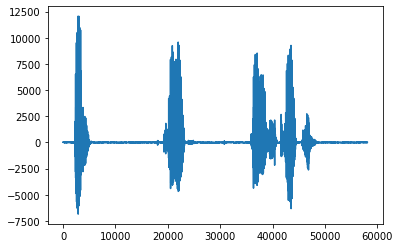

In [18]:
plt.plot(w)
plt.show()

In [19]:
Audio(w,rate=16000)